# Simulated Galaxies: The Return (New Galaxies)

What we want in this notebook is to create and test several schemes to generate galaxy images. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [17]:
import galsim
import tensorflow as tf
import tensorflow_datasets as tfds
import autometacal
import tqdm
import os
from astropy.table import Table

In [56]:
cat?

Type:        COSMOSCatalog
String form: <galsim.scene.COSMOSCatalog object at 0x7f6876611b80>
Length:      81499
File:        ~/.local/lib/python3.8/site-packages/galsim/scene.py
Docstring:  
A class representing a random subsample of galaxies from the COSMOS sample with F814W<25.2
(default), or alternatively the entire sample with F814W<23.5.

Depending on the keyword arguments, particularly ``use_real``, the catalog will either have
information about real galaxies, and/or parametric ones.  To use this with either type of
galaxies, you need to get the COSMOS datasets in the format that GalSim recognizes; see

https://github.com/GalSim-developers/GalSim/wiki/RealGalaxy-Data

option (1) for more information.  Note that if you want to make real galaxies you need to
download and store the full tarball with all galaxy images, whereas if you want to make
parametric galaxies you only need the catalog real_galaxy_catalog_25.2_fits.fits (and the
selection file real_galaxy_catalog_25.2_selectio

In [55]:
cat = galsim.COSMOSCatalog(dir = os.path.expanduser('~/Data/COSMOS_25.2_training_sample'))
catable=Table(cat.param_cat)
catable

IDENT,mag_auto,flux_radius,zphot,sersicfit [8],bulgefit [16],fit_status [5],fit_mad_s,fit_mad_b,fit_dvc_btt,use_bulgefit,viable_sersic,hlr [3],flux [4]
int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,int32,int32,float64,float64
1286742,25.074556350708008,5.665686130523682,0.9444000124931335,0.013805730165296373 .. 0.7271818199862898,0.013722619128874446 .. 0.8261436144591823,1 .. 1,0.002050128135597444,0.0020607960657673327,0.0022140486678908027,0,1,0.10870585950506657 .. 0.0,2.1602487977063904 .. 0.0
782514,24.985071182250977,5.427647113800049,1.4241000413894653,0.014409754401637312 .. 2.412473286905461,0.012780175388374785 .. -0.8580977101162014,1 .. 1,0.00294126016306956,0.003090797056980981,0.47342119317981024,0,1,0.0974461731996633 .. 0.0,2.699868382752252 .. 0.0
52167,23.126625061035156,14.171381950378418,1.0190000534057617,0.00721210624489112 .. 1.2718716075894045,0.005778727948074379 .. 1.9695011915783498,1 .. 1,0.0027478740052489627,0.002724644497289763,0.037447996074410954,0,1,0.3842748018398006 .. 0.0,13.761680581733447 .. 0.0
70378,23.61808204650879,13.591012954711914,1.0312000513076782,0.006534871271120474 .. 0.45811157491022814,0.0040667777411650735 .. 0.5284126159980042,1 .. 1,0.0021667774104480782,0.002295922202999617,0.0,0,1,0.3586576280712098 .. 0.0,8.280230201407937 .. 0.0
1108730,24.99716567993164,6.59538459777832,1.7522000074386597,0.016248464637488275 .. 0.6580086082499662,0.008625983269181311 .. -1.7052708449727527,1 .. 1,0.003077972603879063,0.003612341885244324,3.0943092548182787e-18,0,1,0.13974938920002375 .. 0.0,2.7105833863623645 .. 0.0
67307,23.807924270629883,8.664006233215332,1.624400019645691,0.017653408361451385 .. 0.9725261193518764,0.01518385073604151 .. 1.7442607426307692,1 .. 1,0.002448468718946181,0.0024542576387947615,0.0062307669339586105,0,1,0.17153760481688798 .. 0.0,6.246499389168932 .. 0.0
466881,25.005207061767578,5.1761698722839355,0.847599983215332,0.012771093093837576 .. 1.0495588409113927,0.0075243214098179 .. 0.6071743951945785,1 .. 1,0.0020499230901729927,0.0018489873128187777,0.39297642584128606,1,1,0.10841086146054124 .. 0.12456734741574446,2.5316978910352583 .. 2.600197556302195
1007568,24.15331268310547,16.072845458984375,1.432800054550171,0.002171383714997691 .. 0.24026111767708222,0.0011669668580383172 .. 0.7176431857570683,1 .. 1,0.0031848260006461025,0.0026981961869623774,0.019939971199413205,0,1,0.49243971404343245 .. 0.0,4.535268860380321 .. 0.0
375923,25.04447364807129,6.306777477264404,0.20649999380111694,0.01117238352055494 .. 1.7567859582964158,0.008306849804422669 .. -2.2242346318701234,1 .. 1,0.0018002365812593586,0.0018954697573489937,0.0,0,1,0.14608723773105015 .. 0.0,2.3560191716091263 .. 0.0


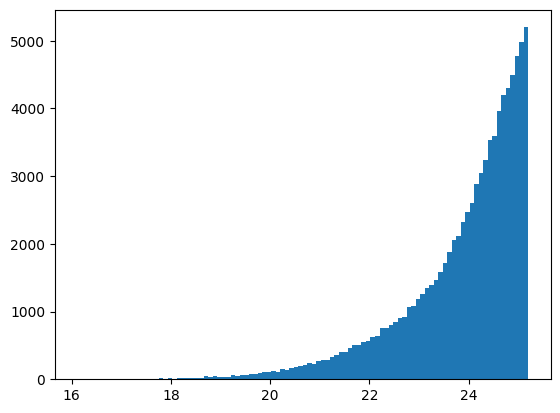

In [44]:
hist(catable['mag_auto'],bins=100);

In [38]:
cat.param_cat[0][1]

25.074556350708008

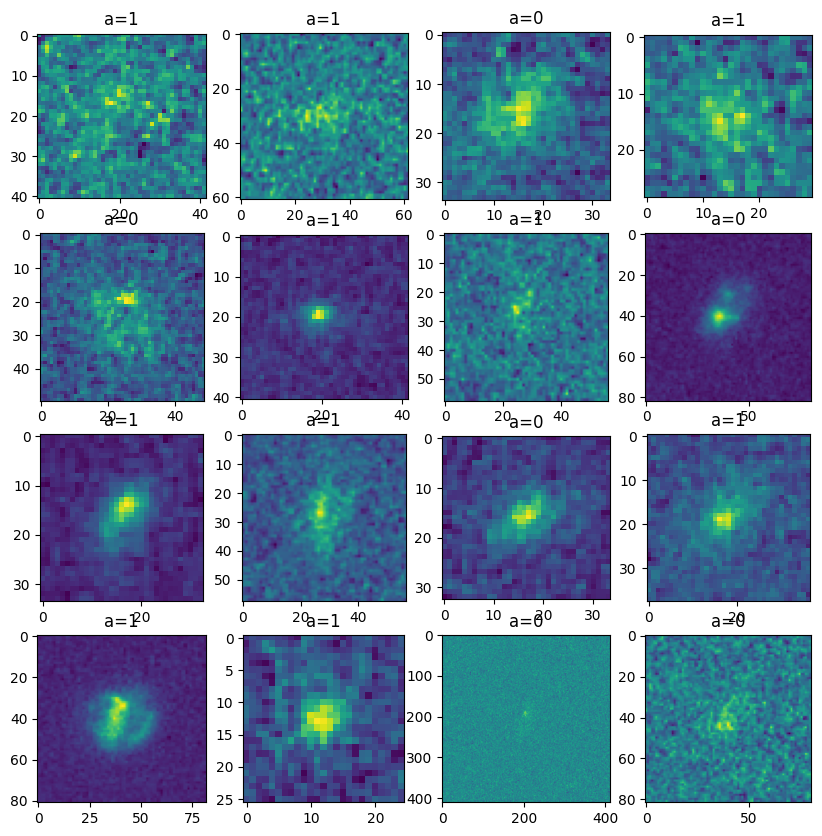

In [57]:
style.use('default')
figure(figsize=(10,10))
j=0
i=0
while i <16:
  subplot(4,4,i+1)
  if cat.param_cat[j][1]<18:
    
    gal = cat.makeGalaxy(index=j,gal_type='real')
    gal_image = gal.gal_image.array
    imshow(gal_image)
    title(f'a={cat.param_cat[j][10]}')
    i=i+1
  j=j+1

AttributeError: 'Transformation' object has no attribute 'gal_image'

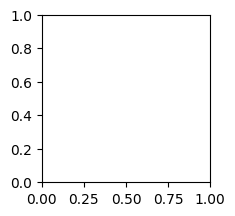

In [58]:
style.use('default')
figure(figsize=(10,10))
j=0
i=0
while i <16:
  subplot(4,4,i+1)
  if cat.param_cat[j][1]<18:
    
    gal = cat.makeGalaxy(index=j,gal_type='parametric')
    gal_image = gal.gal_image.array
    imshow(gal_image)
    title(f'a={cat.param_cat[j][10]}')
    i=i+1
  j=j+1

In [63]:
gal

galsim.Transformation(galsim.Sersic(n=3.9000000000000004, scale_radius=0.0002807078515562031, trunc=0.0, flux=5.315599301117777, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), jac=[[0.8750296731925037, -0.8427506994079677], [-0.8427506994079677, 1.9544808521897683]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=1.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)

In [ ]:
random_seed = 31415
def make_COSMOS_parametric(Ngals=1,stamp_size=51,psf_fwhm=1.,pixel_scale=.2,**kwargs):
  pixel_scale_hst = 0.03 # HST pixel scale
   
  ###defaults
  exp_time = 200 #seconds # exposure time #value corresponding to CFIS # provided by A. Guinot
  sky_brightness = 21.30 #mag/arcsec^2 # for Dark sky, Moon 0%
  zero_point = 10.72 #ADU/sec
  cfht_eff_area = 8.022 #m^2 #effective area
  qe = 0.77 # Quantum Efficiency (converts photon number to electrons)
  gain = 1.62 #e-/ADU #converts electrons to ADU
   
  flux = exp_time*zero_point*10**(-0.4*(sky_brightness-24)) / gain #sky flux
  mean_sky_level = flux * pixel_scale ** 2
 
  #make a simple galaxy from COSMOS catalogue
  gal_image_list = []
  psf_image_list = []
  cat = galsim.COSMOSCatalog(dir = os.path.expanduser('~/Data/COSMOS_25.2_training_sample'))
  dev = galsim.BaseDeviate(random_seed)
  for gal_ind in range(Ngals):
    wcs = galsim.wcs.PixelScale(pixel_scale) 
    
    gal = cat.makeGalaxy(gal_ind, noise_pad_size = stamp_size * pixel_scale_hst * np.sqrt(2))
    psf = galsim.Kolmogorov(fwhm=psf_fwhm,flux=1.0)
    gal = galsim.Convolve(gal, psf)

    #scale the flux to match CFHT
    hst_eff_area = 2.4**2 * (1.-0.33**2)
    flux_scaling = (cfht_eff_area/hst_eff_area) * exp_time * qe / gain
    gal *= flux_scaling

    gal_im = gal.drawImage(wcs=wcs, nx=stamp_size,ny=stamp_size)
    psf_im = psf.drawImage(nx=stamp_size,ny=stamp_size)
    
    # Fadi's MAD noise estimator.
    signal = gal_im.array
    hst_var = 1.4826*np.median(np.abs(signal-np.median(signal)))
    
    
    #apply noise to the parametric image
    delta_var = mean_sky_level - hst_var
    noise = galsim.GaussianNoise(dev, sigma=np.sqrt(delta_var))    
   
    gal_im.addNoise(noise)

    gal_image = gal_im.array
    psf_image = psf_im.array
    gal_image_list.append(gal_image)
    psf_image_list.append(psf_image)
    
  
  gal_images = tf.stack(gal_image_list)
  psf_images = tf.stack(psf_image_list)
 
  return gal_images, psf_images

In [ ]:
gal_images, _  = make_COSMOS_parametric(Ngals=1000)

In [ ]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

In [ ]:
banana();

In [ ]:
gal_images = 
psf_images = make_data()

# Autodiff Test

In [ ]:
def line_and_contours(lines,percentiles=[2.5,16,50,84,97.5]):
  line_and_contours = np.percentile(lines,percentiles,axis=1)
  return line_and_contours

In [ ]:
steps = logspace(-5,0,100)

In [ ]:
reconv_psf = galsim.Moffat(beta=2.5, 
                    fwhm=0.9*1.2)
reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(
  reconv_psf.drawImage(nx=51, 
                       ny=51, 
                       scale=.2).array),axis=0)

In [ ]:
def get_ellipticities(image):
  return autometacal.gaussian_moments(image,0.2,1.2)

In [ ]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = autometacal.metacal.get_metacal_response_finitediff(gal_images,
                                                         psf_images,
                                                         reconv_psf_image,
                                                         step=step,method=get_ellipticities)
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
    
R_finite=np.array(R_finite_list)

In [ ]:
e_auto, R_auto = autometacal.get_metacal_response(gal_images[:2500],psf_images[:2500],reconv_psf_image,get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

In [ ]:
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[abs(e_auto[:,0])<1],bins=100,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[abs(e_auto[:,0])<1],bins=100,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[abs(e_auto[:,0])<1],bins=100,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[abs(e_auto[:,0])<1],bins=100,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)
savefig('response_simple.png',bbox_inches='tight')

In [ ]:
style.use('ggplot')

figure(figsize=(16,5))
subplot(121)

Y00_95, Y00_84, Y00_median, Y00_16, Y00_5 = line_and_contours(abs(R_auto[:,0,0]-R_finite[:,:,0,0]))
fill_between(steps, Y00_5,Y00_95,color='red',alpha=0.1)####CL95
fill_between(steps, Y00_16,Y00_84,color='red',alpha=0.3)####CL68
plot(steps,Y00_median,label="R_{11}",color='red')####Median 

Y11_95, Y11_84, Y11_median, Y11_16, Y11_5 = line_and_contours(abs(R_auto[:,1,1]-R_finite[:,:,1,1]))
fill_between(steps, Y11_5,Y11_95,color='darkblue',alpha=0.1)####CL95
fill_between(steps, Y11_16,Y11_84,color='darkblue',alpha=0.3)####CL68
plot(steps,Y11_median,label="R_{22}",color='darkblue')####Median 
plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel('$R_{auto}$ - $R_{finite}$',fontsize=20)
legend()
xscale('log')
yscale('log')

subplot(122)

Y10_95, Y10_84, Y10_median, Y10_16, Y10_5 = line_and_contours(abs(R_auto[:,1,0]-R_finite[:,:,1,0]))
fill_between(steps, Y10_5,Y10_95,color='red',alpha=0.1)####CL95
fill_between(steps, Y10_16,Y10_84,color='red',alpha=0.3)####CL68
plot(steps,Y10_median,label="R_{21}",color='red')####Median 

Y01_95, Y01_84, Y01_median, Y01_16, Y01_5 = line_and_contours(abs(R_auto[:,0,1]-R_finite[:,:,0,1]))
fill_between(steps, Y01_5,Y01_95,color='darkblue',alpha=0.1)####CL95
fill_between(steps, Y01_16,Y01_84,color='darkblue',alpha=0.3)####CL68
plot(steps,Y01_median,label="R_{12}",color='darkblue')####Median 

plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel("$R_{auto}$ - $R_{finite}$",fontsize=20)
legend()
xscale('log')
yscale('log')
savefig('simple.png',bbox_inches='tight')